# Running Wflow using the ewatercycle system

### 1. Copy an example case
To run WFlow, we need a complete parameterset. The easiest way to obtain a valid model configuration is by copying it from https://github.com/openstreams/wflow/raw/master/examples/. We can use `ewatercycle.parametersetdb` to easily copy on of these example cases to a folder called `./wflow_example_case`.

In [ ]:
from ewatercycle.parametersetdb import build_from_urls

# Obtain an example case for testing the model
parameterset = build_from_urls(
    config_format='ini', config_url='https://github.com/openstreams/wflow/raw/master/examples/wflow_rhine_sbm/wflow_sbm.ini',
    datafiles_format='svn', datafiles_url='https://github.com/openstreams/wflow/trunk/examples/wflow_rhine_sbm',
)
parameterset.save_datafiles('./wflow_example_case')

### 2. Verify your configuration settings

If you are working on a curated environment like https://lab.ewatercycle.org/, the default configuration should cover 90% of all use cases. However, for the other 10% here is a brief explanation of the relevant configuration settings. 

The ewatercycle configuration file is typcially stored in `~/ewatercycle/ewatercycle.yaml` or `/etc/ewatercycle.yaml` and can be imported with `from ewatercycle import CFG`. Relevant settings for WFLow are:

```Yaml
container_engine: docker # or singularity
singularity_images.wflow: 'ewatercycle-wflow-grpc4bmi.sif'
docker_images.wflow: 'ewatercycle/wflow-grpc4bmi:latest'
scratch_dir: './' # the directory where the model work_dir will be created
```

In order for this to work, you need to make sure that the actual docker or singularity images are available on the system. This can be done with:

- Docker: `docker pull ewatercycle/wflow-grpc4bmi:latest`
- Singularity: `singularity build --disable-cache ewatercycle-wflow-grpc4bmi.sif docker://ewatercycle/wflow-grpc4bmi:latest`

### 3. Setting up the model

In [1]:
from ewatercycle.models import Wflow

In [2]:
model = Wflow()

In [3]:
model.parameters

NotImplementedError: No default parameters available for wflow. To see the parameters, first run setup with a valid .ini file.

In [4]:
# This should work for a well-defined example case
# cfg_dir, cfg_file = model.setup(cfg_dir='wflow_example_case/', cfg_file='./wflow_example_case/wflow_sbm.ini')

# You can also add custom settings to overwrite whatever is in the cfg_file. 
# This is useful, as the WFLOW version we're using is inconsistent with the example config file. We need to add the RiverRunoff variable to the API section in the .ini-file:
cfg_file, cfg_dir = model.setup(cfg_dir='wflow_example_case/', cfg_file='./wflow_example_case/wflow_sbm.ini', API={"RiverRunoff": "2, m^3/s"})

Working directory created: /home/peter/ewatercycle/ewatercycle/examples/wflow_20210415_151912
Created /home/peter/ewatercycle/ewatercycle/examples/wflow_20210415_151912/wflow_ewatercycle.ini.
Started wflow container with working directory /home/peter/ewatercycle/ewatercycle/examples/wflow_20210415_151912


In [5]:
cfg_file, cfg_dir

(PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_20210415_151912/wflow_ewatercycle.ini'),
 PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_20210415_151912'))

The `config_file` that is returned by `setup(...)` can be used to initialize the model:

In [6]:
# Print a list of currently used parameters
model.parameters

[('inputmapstacks.Precipitation', '/inmaps/P'),
 ('inputmapstacks.EvapoTranspiration', '/inmaps/PET'),
 ('inputmapstacks.Temperature', '/inmaps/TEMP'),
 ('inputmapstacks.Inflow', '/inmaps/IF'),
 ('run.starttime', '1995-01-31 00:00:00 GMT'),
 ('run.endtime', '1995-02-28 00:00:00 GMT'),
 ('run.runinfo', 'None'),
 ('run.timestepsecs', '86400'),
 ('run.reinit', '0'),
 ('model.modeltype', 'sbm'),
 ('model.AnnualDischarge', '2290'),
 ('model.Alpha', '120'),
 ('model.ModelSnow', '0'),
 ('model.ScalarInput', '0'),
 ('model.InterpolationMethod', 'inv'),
 ('model.WIMaxScale', '0.8'),
 ('model.Tslice', '1'),
 ('model.UpdMaxDist', '300000.0'),
 ('model.origTopogLateral', '1'),
 ('model.configfile', 'wflow_sbm.ini'),
 ('model.reinit', '0'),
 ('model.fewsrun', '0'),
 ('model.OverWriteInit', '0'),
 ('model.updating', '0'),
 ('model.updateFile', 'no_set'),
 ('model.lateralmethod', '1'),
 ('model.sCatch', '0'),
 ('model.intbl', 'intbl'),
 ('model.timestepsecs', '86400'),
 ('model.MaxUpdMult', '1.3'),
 

### 4. Running the model

In [7]:
cfg_file

PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_20210415_151912/wflow_ewatercycle.ini')

In [8]:
# This conversion to string shouldn't be necessary
model.initialize(str(cfg_file))

In [9]:
model.get_value("RiverRunoff")

array([-999., -999., -999., ..., -999., -999., -999.])

In [10]:
model.get_value_as_xarray("RiverRunoff")  # this automatically converts the -999 values to NaN

<xarray.DataArray 'RiverRunoff' (latitude: 169, longitude: 187)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
    time       object 1995-01-30 00:00:00
Attributes:
    units:     m^3/s

In [11]:
import numpy as np
model.bmi.get_value_at_indices("RiverRunoff", np.array([100]))

array([-999.])

In [12]:
while model.time < model.end_time:
    print(model.time)
    model.update()

791424000.0
791510400.0
791596800.0
791683200.0
791769600.0
791856000.0
791942400.0
792028800.0
792115200.0
792201600.0
792288000.0
792374400.0
792460800.0
792547200.0
792633600.0
792720000.0
792806400.0
792892800.0
792979200.0
793065600.0
793152000.0
793238400.0
793324800.0
793411200.0
793497600.0
793584000.0
793670400.0
793756800.0
793843200.0


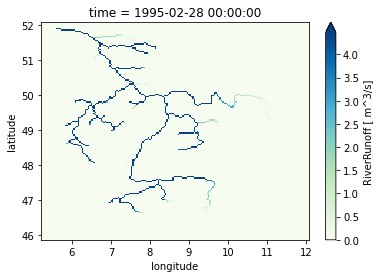

In [13]:
da = model.get_value_as_xarray("RiverRunoff")
da.plot(robust=True, cmap='GnBu')

In [14]:
model.finalize()

In [15]:
del(model)